### 0. データの準備
まず、ウェブ検索で画像を取得する方法を説明する。  
icrawlerというライブラリを使って、次のように画像の検索・保存を行う。  
BingImageCrawlerで保存するフォルダの指定を行い、crawlで検索ワードをkeywordで指定する。  
max_numで検索数を指定できるが、画像の中には保存できないものもあり、max_num通りにならないので注意する。  
例えば以下の場合、「日立建機 建設機械」で検索された画像が「image/日立建機」フォルダに、「コマツ 建設機械」で検索された画像が「image/コマツ」フォルダに保存される。  
保存された画像の中には対象外のものも含まれるため、最終的には目視で確認して取捨選択する。

In [9]:
from icrawler.builtin import BingImageCrawler

for name in ['日立建機','コマツ']:
    crawler = BingImageCrawler(storage = {"root_dir" : ('image/'+name)})
    crawler.crawl(keyword = name+' 建設機械', max_num = 3)

2022-05-16 20:06:11,669 - INFO - parser - parser-001 is waiting for new page urls
2022-05-16 20:06:12,047 - INFO - downloader - downloader-001 is waiting for new download tasks
2022-05-16 20:06:12,432 - INFO - parser - parser-001 is waiting for new page urls


取得された画像群をtrain用とvalidation用に分ける。  
trainフォルダとvalidationファルダを作成し、その中にカテゴリごとのフォルダを作り画像を格納する。

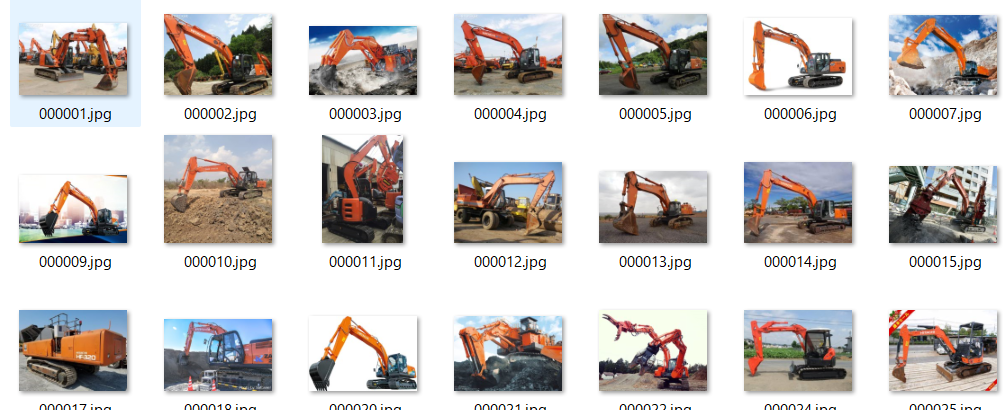

### 1. 予測モデルの作成

ここでは次の3つの学習方法について説明する。

1. 転移学習
2. ファインチューニング
3. 自作モデル


1,2については学習済みモデルを利用した学習であり、少ない枚数の画像で精度の高いモデルが作成できる。  
3は自分で実装するもので、自由にモデルを作成できるが、学習用の画像が多く必要となる。

#### 1.1 転移学習
#### 1.1.1 モデルの準備
kerasで用意されている学習済みモデルを使い転移学習を行う。  
学習済みモデルはImageNetと呼ばれる大規模データセットで学習されたものであり、1000クラスの分類モデルとなっている。  
これを目的のクラス数の分類モデルとするため、転移学習では学習済みモデルの出力部分を書き換えて、書き換えた部分のみを再学習させる。  

今回はkeras.applicationsに実装されている「MobileNet V3(small)」で使用方法を説明する。  
モデルの読み込みの際に、include_topをFalseとすることで出力部分が読み込まれないので、この後に層を追加して目的のモデルとする。

追加部分以外を学習させないために、各レイヤのtrainableをFalseとする。

モデルに関しては他にも、
- Xception
- VGG16
- VGG19
- ResNet50
- InceptionV3
- InceptionResNetV2
- MobileNet
- DenseNet
- NASNet
- MobileNetV2

などが用意されている。

また、最適化手法については、
- Adadelta
- Adagrad
- Adam
- Adamax
- Ftrl
- Nadam
- RMSprop
- SGD

などがある。

実際にモデルの準備を行う。

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import keras

from keras.applications.mobilenet_v3 import MobileNetV3Small
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [104]:
input_shape = (224,224,3)
num_classes = 1 # 2値分類なので1 多クラスであればクラス数

# 学習済みモデルの読み込み
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)

# 全結合層の追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x) # 多クラス:'softmax'

# モデルの再定義
model = Model(inputs=base_model.input, outputs=output)

# 追加部分以外は学習させない
for layer in base_model.layers:
    layer.trainable = False

# 最適化手法の設定
optimizer = Adam(lr=0.01)

# モデルのコンパイル
model.compile(loss=['binary_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'],) # 多クラス'categorical_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


model.summary()とすることで、モデルの構成を確認できる。  
特に最後の「Trainable params」「Non-trainable params」を確認することで追加部分に以外は学習されないことが確認できる。

In [113]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

#### 1.1.2 データの準備
今回は画像を読み込まずフォルダを指定してデータセットの準備を行う。  
ImageDataGeneratorで、画像の「前処理」や「水増し」の設定が行う。特に今回のように画像の枚数が少ないときは水増しして過学習が起きないようにする。  
今回はkeras.applications.mobilenet_v3.preprocess_inputで用意された前処理のみを利用する。  
train用とvalidation用のImageDataGeneratorを定義した後は、flow_from_directoryにより画像読み込みの設定を行う。  
それぞれ、train用画像とvalidation用画像の保存されたフォルダを指定する。

ImageDataGeneratorの引数には次のようなものがある。

- featurewise_center: 真理値．データセット全体で，入力の平均を0にします．
- samplewise_center: 真理値．各サンプルの平均を0にします．
- featurewise_std_normalization: 真理値．入力をデータセットの標準偏差で正規化します．
- samplewise_std_normalization: 真理値．各入力をその標準偏差で正規化します．
- zca_epsilon: ZCA白色化のイプシロン．デフォルトは1e-6．
- zca_whitening: 真理値．ZCA白色化を適用します．
- rotation_range: 整数．画像をランダムに回転する回転範囲．
- width_shift_range: 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲．
- height_shift_range: 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲．
- shear_range: 浮動小数点数．シアー強度（反時計回りのシアー角度）．
- zoom_range: 浮動小数点数または[lower，upper]．ランダムにズームする範囲．浮動小数点数が与えられた場合，[lower, upper] = [1-zoom_range, 1+zoom_range]です．
- channel_shift_range: 浮動小数点数．ランダムにチャンネルをシフトする範囲．
- fill_mode: {"constant", "nearest", "reflect", "wrap"}のいずれか．デフォルトは 'nearest'です．指定されたモードに応じて，入力画像の境界周りを埋めます．
"constant": kkkkkkkk|abcd|kkkkkkkk (cval=k)
"nearest": aaaaaaaa|abcd|dddddddd
"reflect": abcddcba|abcd|dcbaabcd
"wrap": abcdabcd|abcd|abcdabcd
- cval: 浮動小数点数または整数．fill_mode = "constant"のときに境界周辺で利用される値．
- horizontal_flip: 真理値．水平方向に入力をランダムに反転します．
- vertical_flip: 真理値．垂直方向に入力をランダムに反転します．
- rescale: 画素値のリスケーリング係数．デフォルトはNone．Noneか0ならば，適用しない．それ以外であれば，(他の変換を行う前に) 与えられた値をデータに積算する．
- preprocessing_function: 各入力に適用される関数です．この関数は他の変更が行われる前に実行されます．この関数は3次元のNumpyテンソルを引数にとり，同じshapeのテンソルを出力するように定義する必要があります．
- data_format: {"channels_first", "channels_last"}のどちらか．"channels_last"の場合，入力のshapeは(samples, height, width, channels)となり，"channels_first"の場合は(samples, channels, height, width)となります．デフォルトはKerasの設定ファイル~/.keras/keras.jsonの- image_data_formatの値です．一度も値を変更していなければ，"channels_last"になります．
- validation_split: 浮動小数点数．検証のために予約しておく画像の割合（厳密には0から1の間）です．

In [ ]:
img_height = 224
img_width = 224

classes = ['hitachi', 'komatsu']

train_datagen = ImageDataGenerator(
        preprocessing_function = keras.applications.mobilenet_v3.preprocess_input)

test_datagen = ImageDataGenerator( preprocessing_function = keras.applications.mobilenet_v3.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=16,
        classes = classes, 
        class_mode='binary'#2つ'binary' 3つ以上:'categorical'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/validation',
        target_size=(img_height, img_width),
        batch_size=16,
        classes = classes, 
        class_mode='binary')

#### 1.1.3 学習の設定

早期終了などの学習の設定を定義する。  
EarlyStoppingは、指定のエポック数で指標の改善が行わなければ学習を終了させるものである。  
ReduceLROnPlateauは、指標の改善が行われなかった場合に学習率の再定義を行うものである。

In [105]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.01,
                          patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            verbose=1, 
                                            factor=0.1,
                                            min_lr=0.00001)
# callback
callbacks = [earlystop, learning_rate_reduction]

#### 1.1.4 学習の実行
学習を実行する。

In [106]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Found 500 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/10
32/32 [==============================] - 11s 267ms/step - loss: 1.6941 - accuracy: 0.5960 - val_loss: 0.4910 - val_accuracy: 0.8429 - lr: 0.0100
Epoch 2/10
32/32 [==============================] - 7s 235ms/step - loss: 0.2825 - accuracy: 0.8960 - val_loss: 0.0251 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 3/10
32/32 [==============================] - 8s 237ms/step - loss: 0.0914 - accuracy: 0.9600 - val_loss: 0.0162 - val_accuracy: 0.9929 - lr: 0.0100
Epoch 4/10
32/32 [==============================] - 8s 238ms/step - loss: 0.2483 - accuracy: 0.9480 - val_loss: 0.0391 - val_accuracy: 0.9929 - lr: 0.0100
Epoch 5/10
32/32 [==============================] - 8s 235ms/step - loss: 0.1666 - accuracy: 0.9500 - val_loss: 0.0367 - val_accuracy: 0.9929 - lr: 0.0100
Epoch 6/10
32/32 [==============================] - 8s 238ms/step - loss: 0.1337 - accuracy: 0.9580 - val_loss: 0.0085 - val_accuracy: 1.0000 

#### 1.1.5 結果の確認
損失及び精度の推移を確認する。
10エポックでtrainとvalidationも収束していることが確認できる。

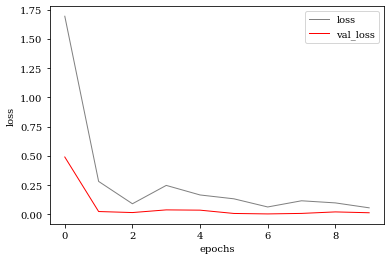

In [107]:
loss = history.history['loss']
val_loss = history.history['val_loss']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss')
plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

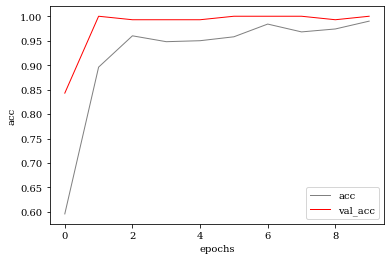

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(acc)), acc, color='gray', linewidth=1, label='acc')
plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

次にtestデータで予測を行う。
結果は次のようになり、2クラスの分類ができていることが確認できた。

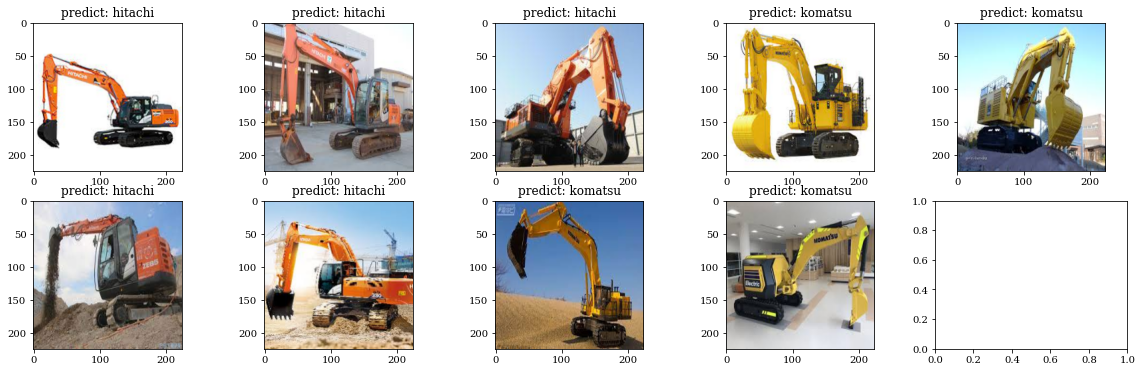

In [110]:
imgs = np.array([cv2.cvtColor(cv2.resize(cv2.imread('/content/drive/MyDrive/test/test/test00'+str(i)+'.jpg'), (224,224)), cv2.COLOR_BGR2RGB) for i in range(1,10)])
imgs = keras.applications.mobilenet_v3.preprocess_input(imgs)

pred = (model(imgs) >= 0.5).numpy()
pred = np.array(list(map(lambda x: 'hitachi' if not x else 'komatsu', pred)))

fig, ax = plt.subplots(2,5,figsize=(20,6))

for i in range(9):
    ax[i%2][i//2].imshow(imgs[i])
    ax[i%2][i//2].set_title('predict: '+pred[i])

最後に、今回のモデルが判定する際に特に注目した部分を可視化する。  
これは、Grad Camと呼ばれるものである。  
それぞれ機械の部分に注目して判定が行われていることが分かる。

In [116]:
K.set_learning_phase(1) #set learning phase

def Grad_Cam(input_model, pic_array, layer_name):
    pic_array = pic_array.reshape(224,224,3)
    X = np.expand_dims(pic_array, axis=0)
    preprocessed_input = X.astype('float32')# / 255.0    

    grad_model = Model([input_model.inputs], [input_model.get_layer(index=layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR) 
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    pic = cv2.cvtColor(pic_array.reshape(224,224,3), cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam)*0.4 + pic*255)/2 # もとの画像に合成
    return np.uint8(jetcam), cam

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


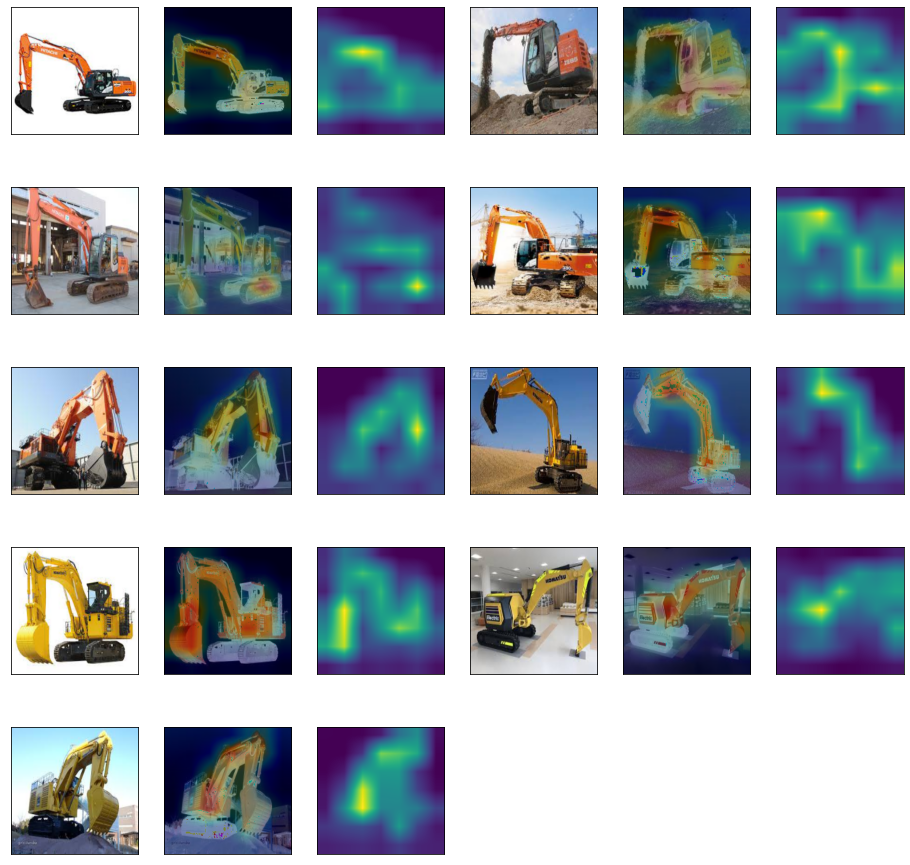

In [121]:
fig = plt.figure(figsize=(16, 16))
#last_conv_layer = model.get_layer('multiply_32')  
last_conv_layer = model.get_layer(index=len(base_model.layers)-1)
i = 1
for img in imgs:
    heatmap, superimposed = Grad_Cam(model, img, len(base_model.layers)-1)

    subplot = fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(224, 224,3), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)
  
    i += 3

####  1.2ファインチューニング
ファインチューニングは転移学習と同様に学習済みモデルを利用するものであるが、追加した部分以外も学習対象とするものである。  
ここではファインチューニングの方法として2種類紹介する。  
1つは転移学習と同じであるが、もう1つはtensorflow_hubを利用したものである。  
#### keras.applicationsによるファインチューニング
転移学習と同様にモデルを作成するが、各層のtrainableをFalseにするような操作はしない。  
ただし、途中まで固定して残りを学習させるなどの方法もある。

In [127]:
input_shape = (224,224,3)
num_classes = 1 # 2値分類なので1 多クラスであればクラス数

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x) # 多クラス:'softmax'

model = Model(inputs=base_model.input, outputs=output)

# 追加部分以外は学習させない
#for layer in base_model.layers[:150]:
#    layer.trainable = False

optimizer = Adam(lr=0.01)

model.compile(loss=['binary_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'],) # 多クラス'categorical_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


途中まで固定させる場合のために、各レイヤが何番目の層なのかを確認しておく。

In [114]:
for i, layer in enumerate(base_model.layers):
    print(str(i)+': ',layer)

0:  <keras.engine.input_layer.InputLayer object at 0x7feb6a0b7650>
1:  <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7feb6eb5ae10>
2:  <keras.layers.convolutional.Conv2D object at 0x7feaecad2c90>
3:  <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7feb6eb62590>
4:  <keras.layers.core.tf_op_layer.TFOpLambda object at 0x7feb6a0d7f90>
5:  <keras.layers.advanced_activations.ReLU object at 0x7feb6a0af990>
6:  <keras.layers.core.tf_op_layer.TFOpLambda object at 0x7feb6a0cd310>
7:  <keras.layers.merge.Multiply object at 0x7feb6a52a290>
8:  <keras.layers.convolutional.ZeroPadding2D object at 0x7feaabe66c50>
9:  <keras.layers.convolutional.DepthwiseConv2D object at 0x7feb6a0a8e50>
10:  <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7feaec8160d0>
11:  <keras.layers.advanced_activations.ReLU object at 0x7feb6a0cdf90>
12:  <keras.layers.pooling.GlobalAveragePooling2D object at 0x7feb6a0d7510>
13:  <keras.layers.

#### データの準備
転移学習と同様である。

In [126]:
img_height = 224
img_width = 224

classes = ['hitachi', 'komatsu']

train_datagen = ImageDataGenerator(
        preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True

)

test_datagen = ImageDataGenerator( preprocessing_function = keras.applications.mobilenet_v3.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=16,
        classes = classes, 
        class_mode='binary'#2つ'binary' 3つ以上:'categorical'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/validation',
        target_size=(img_height, img_width),
        batch_size=16,
        classes = classes, 
        class_mode='binary')

Found 500 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


#### 学習
転移学習と同様である。
ただし、転移学習より収束が遅いのでエポック数に注意する。

In [129]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.01,
                          patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            verbose=1, 
                                            factor=0.1,
                                            patience=5,
                                            min_lr=0.00001)
# callback
callbacks = [earlystop, learning_rate_reduction]

history = model.fit(
        train_generator,
        epochs=70,
        validation_data=validation_generator,
        callbacks=callbacks)

Epoch 1/70
32/32 [==============================] - 18s 432ms/step - loss: 1.0531 - accuracy: 0.7100 - val_loss: 62202.2227 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/70
32/32 [==============================] - 12s 380ms/step - loss: 0.2005 - accuracy: 0.9180 - val_loss: 498744.2188 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/70
32/32 [==============================] - 12s 387ms/step - loss: 0.2196 - accuracy: 0.9480 - val_loss: 626201.8750 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/70
32/32 [==============================] - 12s 388ms/step - loss: 0.1802 - accuracy: 0.9600 - val_loss: 1389176.1250 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/70
32/32 [==============================] - 12s 390ms/step - loss: 0.1784 - accuracy: 0.9500 - val_loss: 264667.8438 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 6/70
32/32 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9760
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
32/32 [==================

#### 結果の確認
転移学習の時と同様に結果の確認を行う。
validationの収束がかなり遅れていることがわかる。

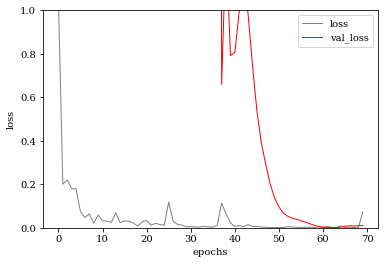

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss')
plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

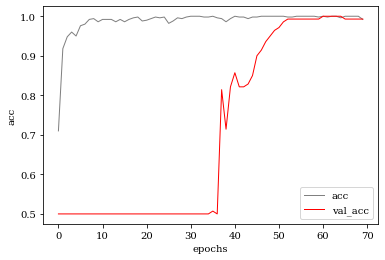

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(acc)), acc, color='gray', linewidth=1, label='acc')
plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

#### tensorflow_hubによるファインチューニング
次にtensorflow_hubを使用したファインチューニングの例を示す。  
torch_hubでは分類モデルに限らず様々なモデルが提供されている。(https://tfhub.dev/)

モデルの読み込みに関してはURLで指定して取得してしまえば、上で説明した学習済みモデル同様に扱うことができる。

In [147]:
model = tf.keras.Sequential([
                             hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5", trainable=True),
                             #GlobalAveragePooling2D(),
                             Dense(512, activation='relu'),
                             Dropout(0.5),
                             Dense(256, activation='relu'),
                             Dropout(0.5),
                             Dense(64, activation='relu'),
                             Dense(num_classes, activation='sigmoid')
                             ])

optimizer = Adam(lr=0.01)

model.compile(loss=['binary_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'],) # 多クラス'categorical_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [145]:
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1024)              1026552   
                                                                 
 dense_277 (Dense)           (None, 512)               524800    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_278 (Dense)           (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_279 (Dense)           (None, 64)                16448     
                                                                 
 dense_280 (Dense)           (None, 1)                

#### データの準備
今までと同様であるが、前処理を自作の関数に置き換える。

In [148]:
def preprocess_input(img):
    img = 2*(img - img.min())/(img.max()-img.min()) - 1
    return img

img_height = 224
img_width = 224

classes = ['hitachi', 'komatsu']

train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True

)

test_datagen = ImageDataGenerator( preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=16,
        classes = classes, 
        class_mode='binary'#2つ'binary' 3つ以上:'categorical'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/validation',
        target_size=(img_height, img_width),
        batch_size=16,
        classes = classes, 
        class_mode='binary')

Found 500 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


#### 学習
学習は今まで同様に実行できる。

In [149]:
history = model.fit(
        train_generator,
        epochs=70,
        validation_data=validation_generator,
        callbacks=callbacks)

Epoch 1/70
32/32 [==============================] - 21s 425ms/step - loss: 1.6920 - accuracy: 0.5180 - val_loss: 11.0730 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 2/70
32/32 [==============================] - 14s 427ms/step - loss: 0.7960 - accuracy: 0.7360 - val_loss: 6.0824 - val_accuracy: 0.8071 - lr: 0.0100
Epoch 3/70
32/32 [==============================] - 13s 401ms/step - loss: 0.5642 - accuracy: 0.9360 - val_loss: 115.4350 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/70
32/32 [==============================] - 13s 411ms/step - loss: 0.9463 - accuracy: 0.7580 - val_loss: 0.9632 - val_accuracy: 0.8071 - lr: 0.0100
Epoch 5/70
32/32 [==============================] - 14s 426ms/step - loss: 0.8890 - accuracy: 0.8520 - val_loss: 26.5733 - val_accuracy: 0.5714 - lr: 0.0100
Epoch 6/70
32/32 [==============================] - 13s 398ms/step - loss: 0.7830 - accuracy: 0.8700 - val_loss: 1175.7936 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 7/70
32/32 [==============================] - 13s 3

#### 結果の確認

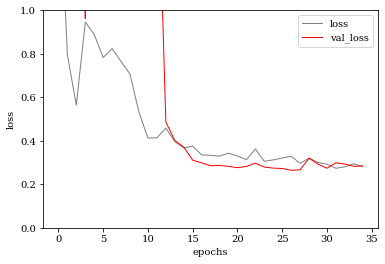

In [152]:
loss = history.history['loss']
val_loss = history.history['val_loss']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss')
plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

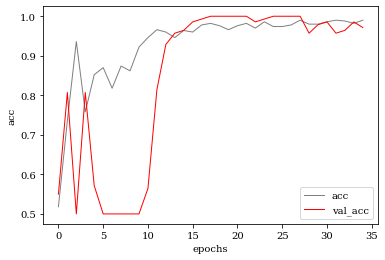

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(acc)), acc, color='gray', linewidth=1, label='acc')
plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [150]:
imgs = np.array([cv2.cvtColor(cv2.resize(cv2.imread('/content/drive/MyDrive/test/test/test00'+str(i)+'.jpg'), (224,224)), cv2.COLOR_BGR2RGB) for i in range(1,10)])
imgs = keras.applications.mobilenet_v3.preprocess_input(imgs)

pred = (model(tf.constant(imgs)) >= 0.5).numpy()
pred = np.array(list(map(lambda x: 'hitachi' if not x else 'komatsu', pred)))

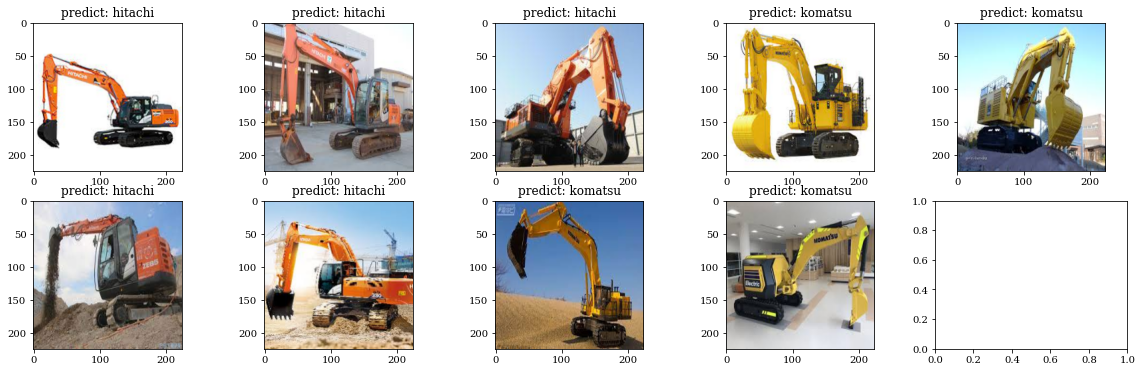

In [151]:
fig, ax = plt.subplots(2,5,figsize=(20,6))

for i in range(9):
    ax[i%2][i//2].imshow(imgs[i])
    ax[i%2][i//2].set_title('predict: '+pred[i])

#### 1.3 自作モデル
自分で定義したモデルの学習を行う。  
転移学習やファインチューニングで層を追加したように畳み込み層の部分も自分で定義したものを使用する。  
ここでは、これまでの例とあわせてMobileNet V3(small)の実装を行う。

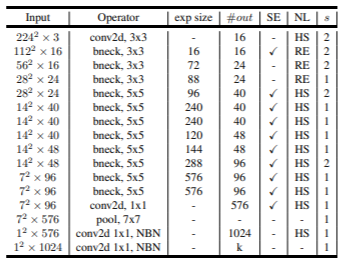

In [53]:
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, DepthwiseConv2D, Add, Multiply, ReLU
from keras.layers.merge import concatenate

def hard_sigmoid(x):
    return ReLU(6.)(x + 3.) * (1. / 6.)

def hard_swish(x):
    return Multiply()([Activation(hard_sigmoid)(x), x])

class SE_Block(Model):
    def __init__(self, in_channels, r=0.25):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(int(in_channels*r))
        self.relu = Activation(hard_sigmoid)
        self.fc2 = Dense(in_channels, activation='sigmoid')
    
    def call(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = Multiply()([out,x])
        return out

class mobilenetv3_block(Model):
    def __init__(self, exp_size, out_channels, kernel, SE, NL, s, r=0.25):
        super().__init__()        
        if NL == 'HS':
            activation = hard_swish
        else:
            activation = "relu"
        
        self.conv1 = Conv2D(filters = int(exp_size), kernel_size = (1,1), padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(activation)
    
        self.conv2 = DepthwiseConv2D(kernel_size = kernel, strides=s, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(activation)

        self.conv3 = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn3 = BatchNormalization()
        self.relu3 = Activation(activation)
        
        if SE:
            self.se = SE_Block(in_channels=out_channels, r=r)
        else:
            self.se = None
        
        if s == 1:
            self.add = Add()
        else:
            self.add = None
    
    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)

        if self.se is not None:
            out = self.se(out)
        
        if K.int_shape(out) == K.int_shape(x):
            if self.add is not None:
                out = self.add([out, x])
            
        return out

In [54]:
class MobileNetV3_Small(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(16, kernel_size=3, strides=2, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(hard_swish)
        
        self.bneck1  = mobilenetv3_block(exp_size=16,  out_channels=16, kernel=3, SE=True,  NL='RE', s=2)
        self.bneck2  = mobilenetv3_block(exp_size=72,  out_channels=24, kernel=3, SE=False, NL='RE', s=2)
        self.bneck3  = mobilenetv3_block(exp_size=88,  out_channels=24, kernel=3, SE=False, NL='RE', s=1)
        self.bneck4  = mobilenetv3_block(exp_size=96,  out_channels=40, kernel=5, SE=True,  NL='HS', s=2)
        self.bneck5  = mobilenetv3_block(exp_size=240, out_channels=40, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck6  = mobilenetv3_block(exp_size=240, out_channels=40, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck7  = mobilenetv3_block(exp_size=120, out_channels=48, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck8  = mobilenetv3_block(exp_size=144, out_channels=48, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck9  = mobilenetv3_block(exp_size=288, out_channels=96, kernel=5, SE=True,  NL='HS', s=2)
        self.bneck10 = mobilenetv3_block(exp_size=576, out_channels=96, kernel=5, SE=True,  NL='HS', s=1)
        self.bneck11 = mobilenetv3_block(exp_size=576, out_channels=96, kernel=5, SE=True,  NL='HS', s=1)
       
        self.conv2 = Conv2D(576, kernel_size=1, strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(hard_swish)
        
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(1024)
        self.relu3 = Activation(hard_sigmoid)
        self.fc2 = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.bneck1(x)
        x = self.bneck2(x)
        x = self.bneck3(x)
        x = self.bneck4(x)
        x = self.bneck5(x)
        x = self.bneck6(x)
        x = self.bneck7(x)
        x = self.bneck8(x)
        x = self.bneck9(x)
        x = self.bneck10(x)
        x = self.bneck11(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

モデルが定義できれば、これまで同様に扱える。

In [94]:
model = MobileNetV3_Small()

optimizer = Adam(lr=0.01)

model.compile(loss=['binary_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'],) # 多クラス'categorical_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### データの準備

In [95]:
img_height = 224
img_width = 224

classes = ['hitachi', 'komatsu']

train_datagen = ImageDataGenerator(
        preprocessing_function = keras.applications.mobilenet_v3.preprocess_input,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True

)

test_datagen = ImageDataGenerator( preprocessing_function = keras.applications.mobilenet_v3.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=16,
        classes = classes, 
        class_mode='binary'#2つ'binary' 3つ以上:'categorical'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/test/validation',
        target_size=(img_height, img_width),
        batch_size=16,
        classes = classes, 
        class_mode='binary')

Found 500 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


#### 学習

In [96]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.01,
                          patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            verbose=1, 
                                            factor=0.1,
                                            patience=3,
                                            min_lr=0.00001)
# callback
callbacks = [earlystop, learning_rate_reduction]

history = model.fit(
        train_generator,
        steps_per_epoch=31,
        epochs=200,
        validation_data=validation_generator,
        callbacks=callbacks)

Epoch 1/200
31/31 [==============================] - 19s 424ms/step - loss: 0.8684 - accuracy: 0.6405 - val_loss: 0.9349 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/200
31/31 [==============================] - 12s 399ms/step - loss: 0.3506 - accuracy: 0.8698 - val_loss: 1.5010 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/200
31/31 [==============================] - 12s 400ms/step - loss: 0.2657 - accuracy: 0.9008 - val_loss: 0.6756 - val_accuracy: 0.5143 - lr: 0.0100
Epoch 4/200
31/31 [==============================] - 12s 398ms/step - loss: 0.3234 - accuracy: 0.8781 - val_loss: 0.4205 - val_accuracy: 0.7929 - lr: 0.0100
Epoch 5/200
31/31 [==============================] - 12s 391ms/step - loss: 0.1306 - accuracy: 0.9587 - val_loss: 0.6239 - val_accuracy: 0.6143 - lr: 0.0100
Epoch 6/200
31/31 [==============================] - 12s 397ms/step - loss: 0.3281 - accuracy: 0.9132 - val_loss: 0.4614 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 7/200
31/31 [==============================] - ETA: 

#### 結果の確認

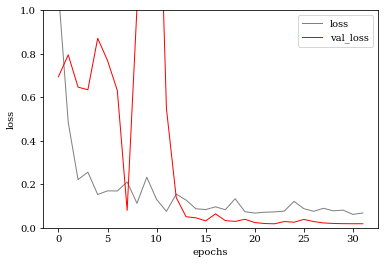

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss')
plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

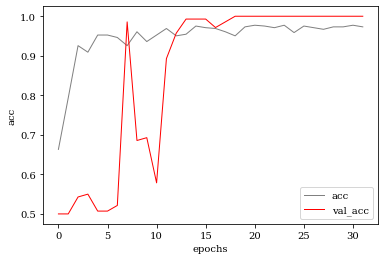

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(acc)), acc, color='gray', linewidth=1, label='acc')
plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [97]:
imgs = np.array([cv2.cvtColor(cv2.resize(cv2.imread('/content/drive/MyDrive/test/test/test00'+str(i)+'.jpg'), (224,224)), cv2.COLOR_BGR2RGB) for i in range(1,10)])
imgs = keras.applications.mobilenet_v3.preprocess_input(imgs.astype(np.float32))

pred = (model(imgs) >= 0.5).numpy()
pred = np.array(list(map(lambda x: 'hitachi' if not x else 'komatsu', pred)))

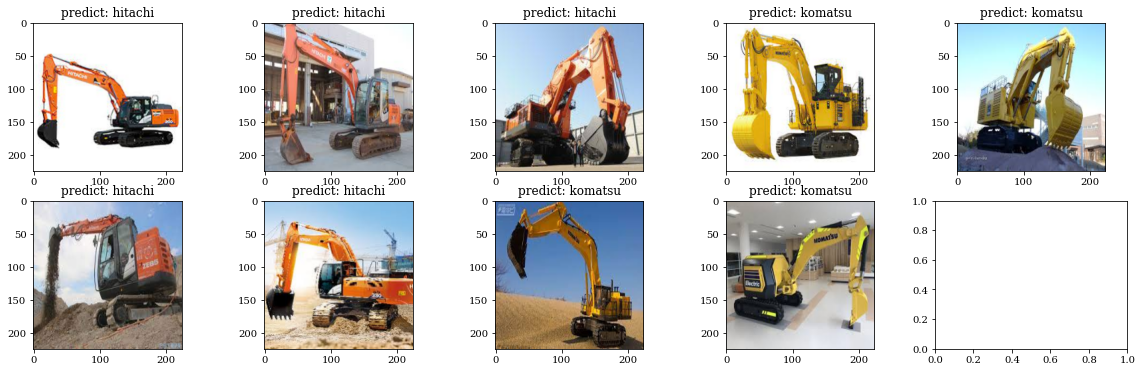

In [99]:
fig, ax = plt.subplots(2,5,figsize=(20,6))
imgs = imgs.astype(int)

for i in range(9):
    ax[i%2][i//2].imshow(imgs[i])
    ax[i%2][i//2].set_title('predict: '+pred[i])